# DEMETER Satellite - IAP Sensor Data Processing

## Calculating correction terms for $\mathrm{H}^{+}$ ion data

Notations used:
- H-ion density: $n_{\mathrm{H}}$
- magnetic latitude: $\Phi_{\mathrm{m}}$
- altitude: $h$

### Initialization

Loading in necessary libraries:

In [70]:
reload(pr)

<module 'demeter.process_data' from 'demeter/process_data.py'>

In [1]:
import demeter.process_data as pr
import demeter.read_data as rd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import stats

from os import listdir

params = {'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

mpl.rcParams.update(params)

%matplotlib inline

Loading data files.

In [2]:
data_dir = '/home/istvan/work/demeter/IAP_data/1140/'
input_paths = [data_dir + path for path in listdir(data_dir)]

In [17]:
# required fields: CNES Julian day, H+ ion densities, magnetic latitude and longitude, altitude
req = ['cnesjd', 'h', 'mlat', 'mlon', 'alt']

# Loading only day data
day, night = rd.read_data(input_paths, required=req, corr_lon=True)

In [18]:
idx_frac, idx_whole = rd.read_idx('/home/istvan/work/demeter/geomag_indices/idx')

In [19]:
# filtering out low ion densities and restricitng mag. lat. values
day = day[(day['h']  < 1.4e4) & (day['h'] > 100) & (np.abs(day['mlat']) < 60)]

Binning data for $\Phi_{\mathrm{m}}$ values and CNES Julian day values. In each case mean $n_{\mathrm{H}}$ values are calulated in each bin.

In [20]:
# bin number for H-ion densities
h_binnum = 1e3

# bin number for Phi_m
mlat_binnum = 120

# bin number for CNES Jd.
cnesjd_binnum = 250;

In [21]:
# half bin width for idx_frac
half_bin_frac = 0.0625

# half bin width for idx_whole
half_bin_whole = 0.5

In [23]:
# creating bins, from max. to min. and calculating mean values

calc_stat=dict()
calc_stat['mean'] = 'mean'

mlat_h = pr.calc_statitistic(day['mlat'], day['h'], statistics=calc_stat, bins=mlat_binnum)

/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:79: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [25]:
cnesjd_h = pr.calc_statitistic(day['cnesjd'], day['h'], statistics=calc_stat, bins=cnesjd_binnum)

In [26]:
cnesjd_ap = pr.calc_statitistic(idx_whole['cnesjd'], idx_whole['ap'], statistics=calc_stat, bins=200)

Plotting 2D histogram of $\Phi_{\mathrm{m}}$ and $n_{\mathrm{H}}$ value pairs and the binned $n_{\mathrm{H}}$ mean values.

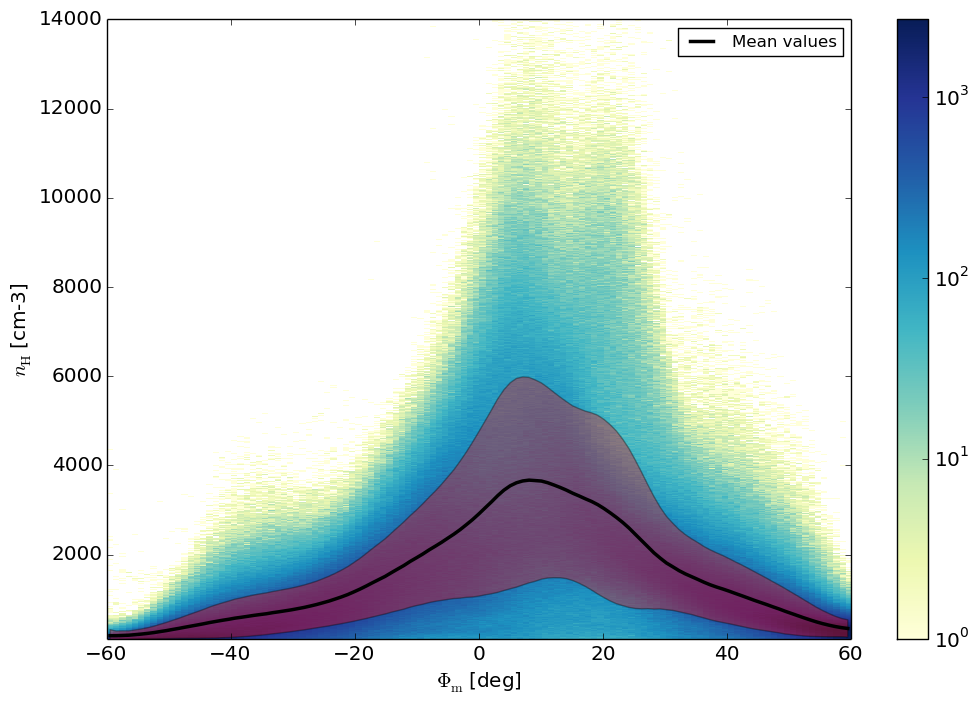

In [77]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

pr.hist2(day['mlat'], day['h'], axis_labels=[r'$\Phi_{\mathrm{m}}$ [deg]', r'$n_{\mathrm{H}}$ [cm-3]'],
        bins=[mlat_binnum, h_binnum])

pr.plot_statistic(mlat_h, shaded='std', color='r', alpha=0.35)
plt.legend();

Plotting 2D histogram of CNES Jd. and $n_{\mathrm{H}}$ value pairs and the binned $n_{\mathrm{H}}$ mean values.

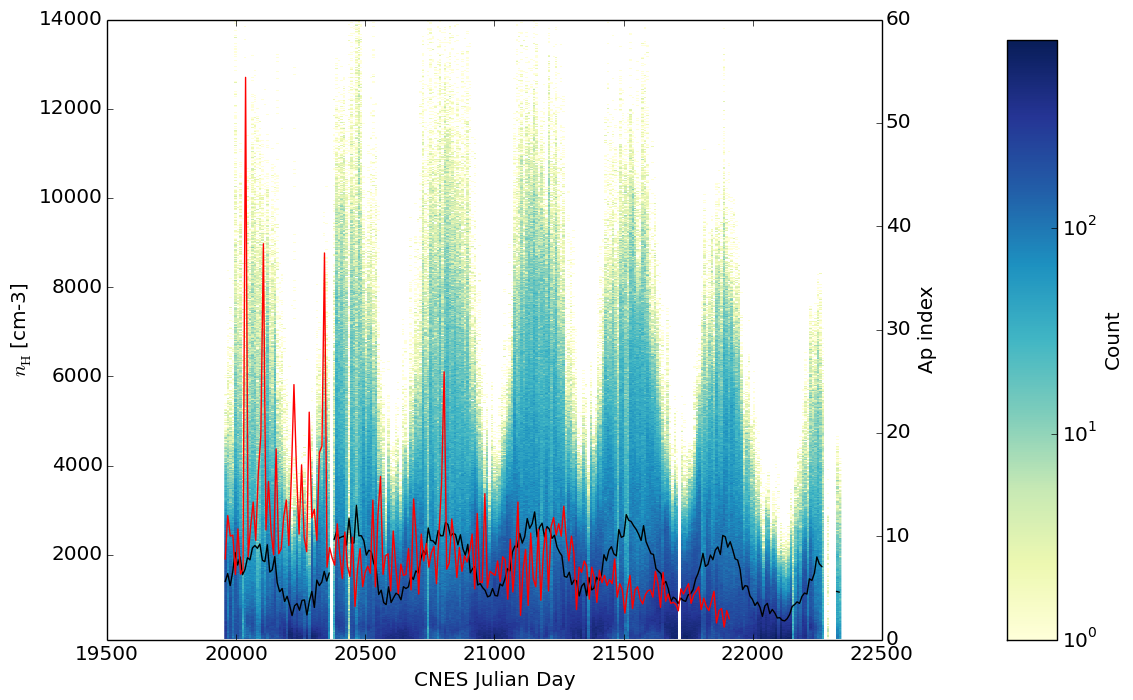

In [44]:
from matplotlib.colors import LogNorm

# plotting 2d histogram and H+ ion median values in bins
fig, ax1 = plt.subplots(figsize=(10,8), dpi=100)

ax1.set_xlabel('CNES Julian Day')
ax1.set_ylabel(r'$n_{\mathrm{H}}$ [cm-3]')

_, _, _, im = ax1.hist2d(day['cnesjd'], day['h'], bins=[cnesjd_binnum, h_binnum], cmap='YlGnBu', norm=LogNorm())

cax = fig.add_axes([1.025, 0.125, 0.05, 0.75])

cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Count')

ax2 = ax1.twinx()

ax1.plot(cnesjd_h['bins'][:-1] + cnesjd_h['half_bin'], cnesjd_h['mean'], 'k-',label='Mean H-ion values')
ax2.plot(cnesjd_ap['bins'][:-1] + cnesjd_ap['half_bin'], cnesjd_ap['mean'], 'r-', label='Ap index')

ax2.set_ylabel('Ap index');

#plt.legend(handles=[label1, label2]);

### Calculating corrections

First let's take a look at the histogram of $\Phi_{\mathrm{m}}$ and $\mathrm{log}_{10} n_{\mathrm{H}}$ value pairs. $\mathrm{log}_{10} n_{\mathrm{H}}$ mean values are alos plotted.

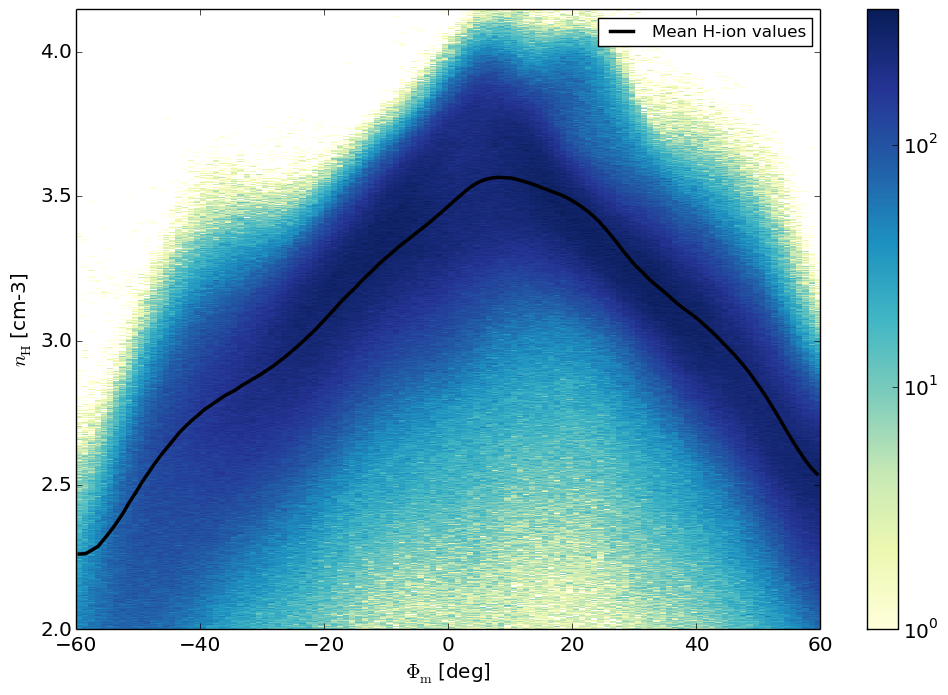

In [45]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

pr.hist2(day['mlat'], np.log10(day['h']), axis_labels=[r'$\Phi_{\mathrm{m}}$ [deg]', r'$n_{\mathrm{H}}$ [cm-3]'],
        bins=[mlat_binnum, h_binnum])

plt.plot(mlat_h['bins'][:-1] + mlat_h['half_bin'], np.log10(mlat_h['mean']),
         'k-', linewidth=2.5, label='Mean H-ion values')
plt.legend();

Now I will fit a polynom to the $\mathrm{log}_{10} n_{\mathrm{H}}$ values.

In [28]:
# fitting 4th order polynom to the log10 n_H values
z, V = np.polyfit(mlat_h['bins'][0:-1] + mlat_h['half_bin'], np.log10(mlat_h['mean']), 4, cov=True)
p = np.poly1d(z)
mlat = np.arange(mlat_h['bins'][0], mlat_h['bins'][-1], 1)

In [30]:
print('Polynom coefficients from highest to lowest order: ', z)

('Polynom coefficients from highest to lowest order: ', array([  2.75458296e-08,  -1.93700420e-06,  -3.89940340e-04,
         8.52695670e-03,   3.44563718e+00]))


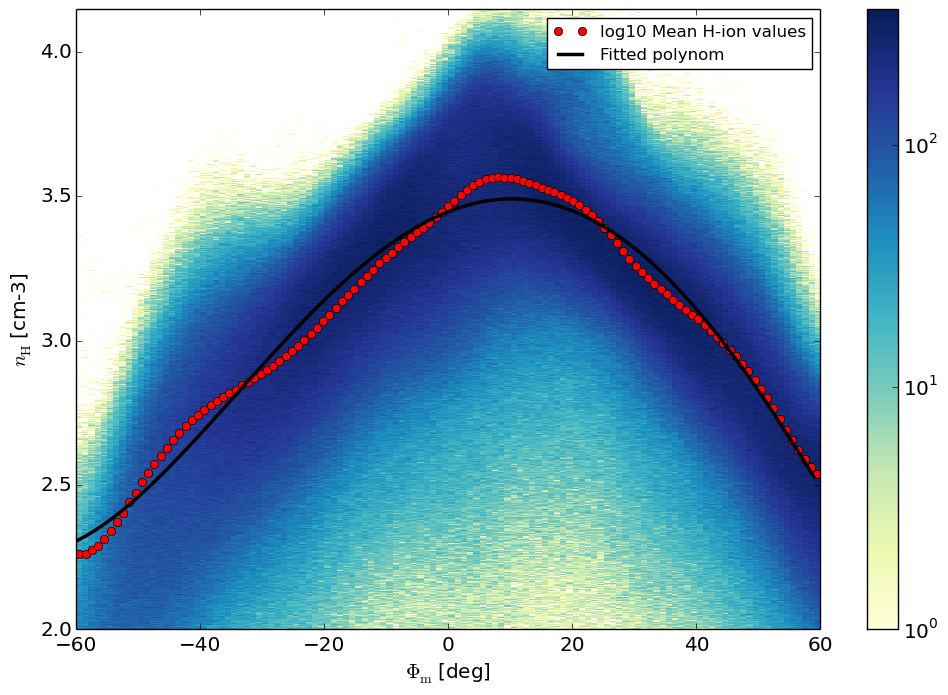

In [32]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

pr.hist2(day['mlat'], np.log10(day['h']), axis_labels=[r'$\Phi_{\mathrm{m}}$ [deg]', r'$n_{\mathrm{H}}$ [cm-3]'],
        bins=[mlat_binnum, h_binnum])

plt.plot(mlat_h['bins'][:-1] + mlat_h['half_bin'], np.log10(mlat_h['mean']),
         'ro', linewidth=2.5, label='log10 Mean H-ion values')
plt.plot(mlat, p(mlat), 'k-', label='Fitted polynom', linewidth=2.5)
plt.legend();

Calculating correction values. I have to raise 10 to the power of evaluated polynom values since we fitted the polynom to $\mathrm{log}_{10} n_{\mathrm{H}}$ values.

In [33]:
h_corr_mlat = np.power(10, p(day['mlat']))

Let's look at the histograms now with the $\Phi_{\mathrm{m}}$ corrected $n_{\mathrm{H}}$ values.

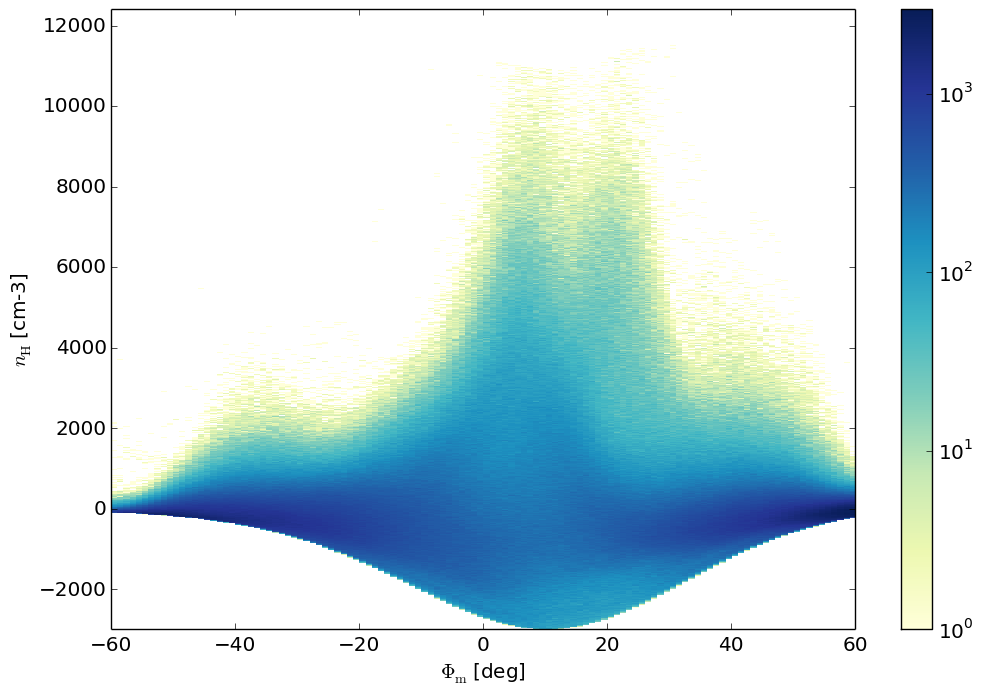

In [34]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

pr.hist2(day['mlat'], day['h'] - h_corr_mlat,
         axis_labels=[r'$\Phi_{\mathrm{m}}$ [deg]', r'$n_{\mathrm{H}}$ [cm-3]'], bins=[mlat_binnum, h_binnum])

#plt.plot(mlat_h['bins'][:-1] + mlat_h['half_bin'], mlat_h['mean'], 'k-', linewidth=2.5, label='Mean H-ion values')
#plt.legend();

The correction reduced standard deviance and pushed $n_{\mathrm{H}}$ values towards zero $\mathrm{cm}^{-3}$.

Recalculating time dependence with the $\Phi_{\mathrm{m}}$ corrected $n_{\mathrm{H}}$ values.

In [40]:
cnesjd_h_corr = pr.calc_statitistic(day['cnesjd'], day['h'] - h_corr_mlat,
                                    statistics=calc_stat, bins=cnesjd_binnum)

In [37]:
# index of non nan values
not_nan = np.logical_not(np.isnan(cnesjd_h_corr['mean']))

Plotting histogram of $\Phi_{\mathrm{m}}$ corrected CNES Jd. and $n_{\mathrm{H}}$ values pairs.

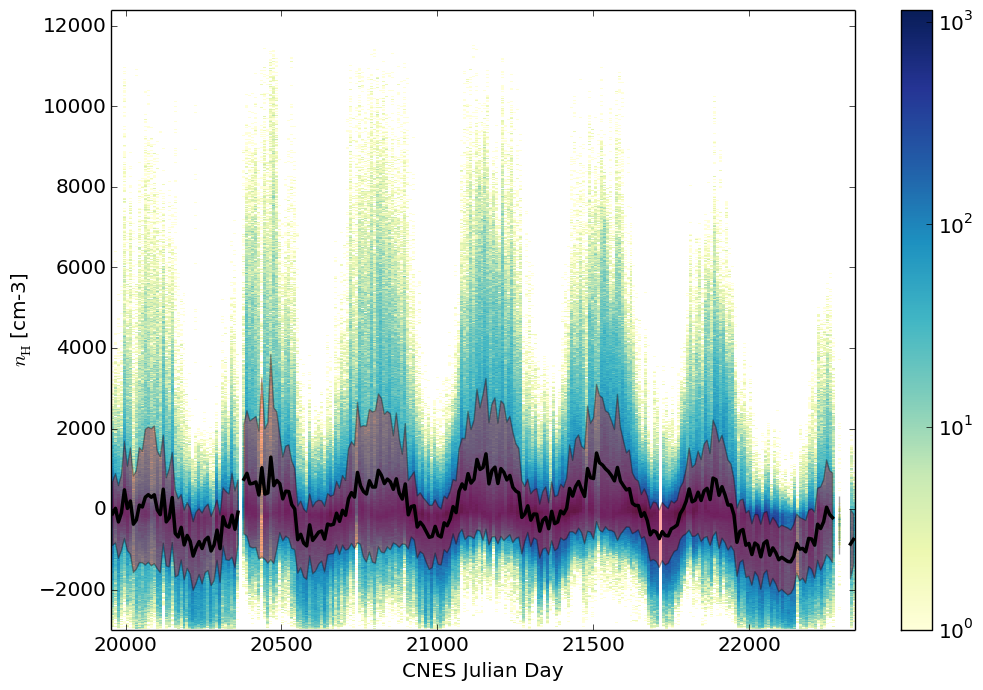

In [78]:
plt.figure(figsize=(12,8), dpi=100)

pr.hist2(day['cnesjd'], day['h'] - h_corr_mlat, axis_labels=['CNES Julian Day', r'$n_{\mathrm{H}}$ [cm-3]'],
        bins=[cnesjd_binnum, h_binnum])

#plt.plot(cnesjd_h_corr['bins'][:-1] + cnesjd_h_corr['half_bin'], cnesjd_h_corr['mean'],
#         'r-', linewidth=2.5, label='Mean H-ion values')
pr.plot_statistic(cnesjd_h_corr, shaded='std', color='r', alpha=0.35)

Now I will calculate temporal correction, interpolating the CNES Jd. mean $n_{\mathrm{H}}$ values to the observed CNES Jd. time points.

In [44]:
# not using nan values
h_corr_cnesjd = np.interp(day['cnesjd'],
                          cnesjd_h_corr['bins'][not_nan] + cnesjd_h_corr['half_bin'],
                          cnesjd_h_corr['mean'][not_nan])

Histogram of $\Phi_{\mathrm{m}}$ and temporally corrected $n_{\mathrm{H}}$ values.

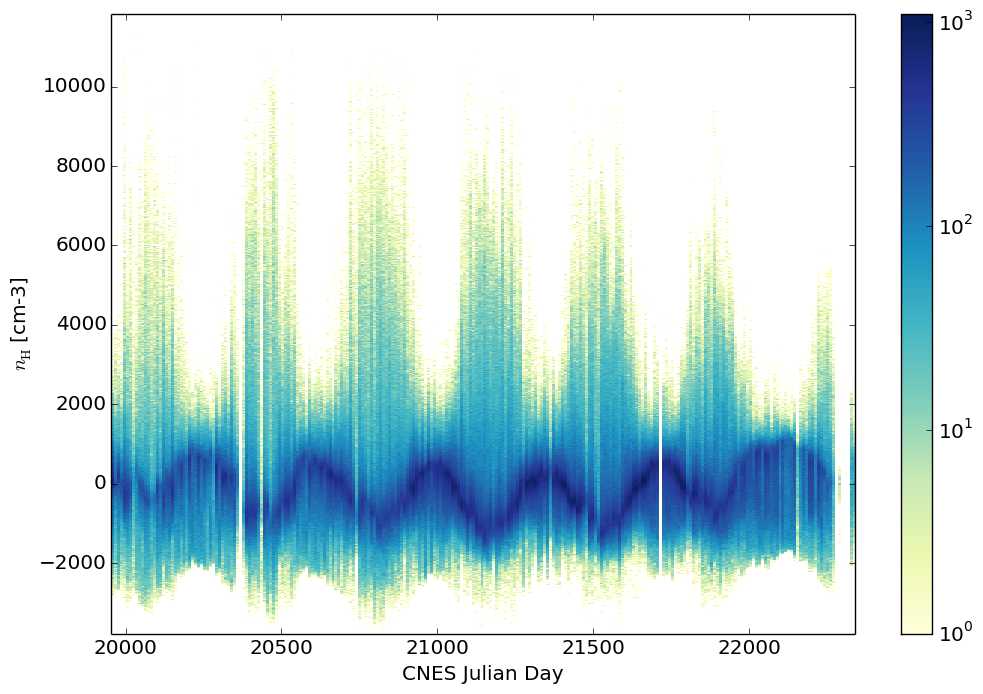

In [45]:
plt.figure(figsize=(12,8), dpi=100)

pr.hist2(day['cnesjd'], day['h'] - h_corr_mlat - h_corr_cnesjd,
         axis_labels=['CNES Julian Day', r'$n_{\mathrm{H}}$ [cm-3]'], bins=[cnesjd_binnum, h_binnum])

Temporal correction pushed high count bins away from $0$ $\mathrm{cm}^{-3}$. But significantly reduced standard deviation.

In [53]:
mlat_h_ccorr = pr.calc_statitistic(day['mlat'], day['h'] - h_corr_mlat- h_corr_cnesjd,
                                    statistics=calc_stat, bins=cnesjd_binnum)

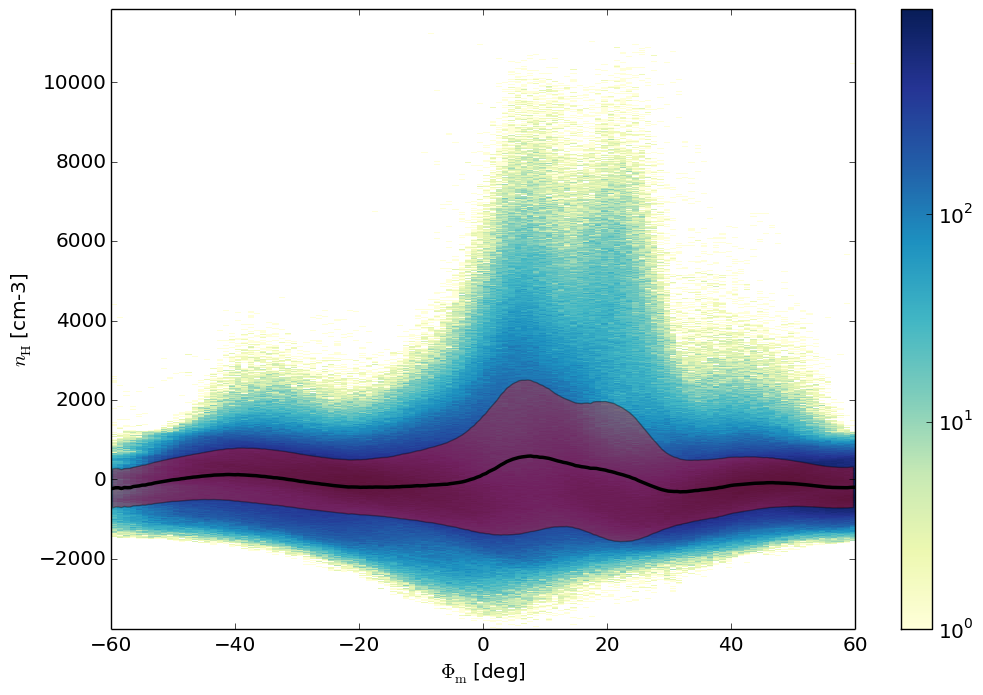

In [79]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

pr.hist2(day['mlat'], day['h'] - h_corr_mlat - h_corr_cnesjd,
         axis_labels=[r'$\Phi_{\mathrm{m}}$ [deg]', r'$n_{\mathrm{H}}$ [cm-3]'], bins=[mlat_binnum, h_binnum])
pr.plot_statistic(mlat_h_ccorr, shaded='std', color='r', alpha=0.35)

Another significant reduction in variance. Now there are even more $n_{\mathrm{H}}$ values around $0$ $\mathrm{cm}^{-3}$.  
Finally I will plot the spatial distribution of uncorrected and corrected $n_{\mathrm{H}}$ values.

In [47]:
h_mean, mlon_edges, mlat_edges, _ = stats.binned_statistic_2d(day['mlon'], day['mlat'], day['h'],
                                                              statistic='mean', bins=[90, 30])

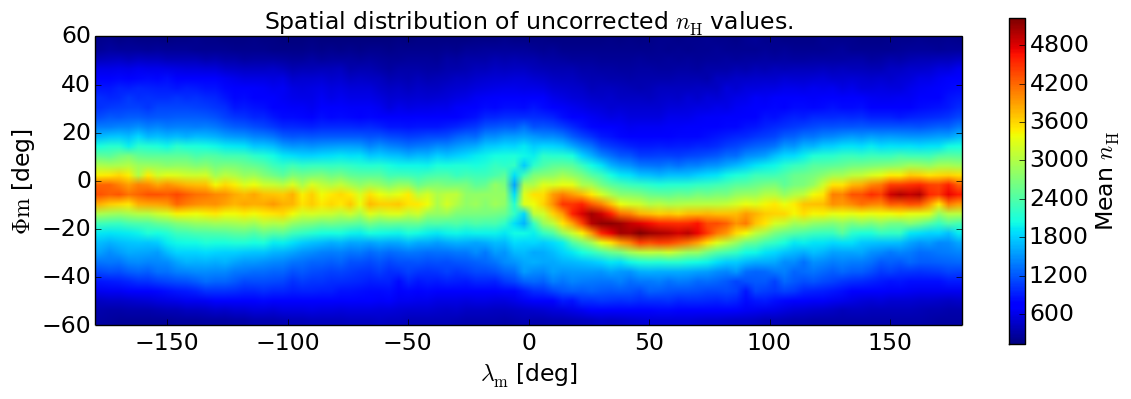

In [49]:
plt.figure(figsize=(12,8), dpi=100)
plt.title(r'Spatial distribution of uncorrected $n_{\mathrm{H}}$ values.', size=17)

plt.xlabel(r'$\lambda_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$\Phi{\mathrm{m}}$ [deg]', size=17)
plt.tick_params(labelsize=17)

im = plt.imshow(h_mean.T, interpolation=None,
           extent=[mlon_edges[0], mlon_edges[-1], mlat_edges[0], mlat_edges[-1]]);

cbar = plt.colorbar(fraction=0.0175)
cbar.set_label('Mean $n_{\mathrm{H}}$', size=17)
cbar.ax.tick_params(labelsize=17)

In [50]:
h_mean_corr, _, _, _ = stats.binned_statistic_2d(day['mlon'], day['mlat'], day['h'] - h_corr_mlat - h_corr_cnesjd,
                                                              statistic='mean', bins=[90, 30])

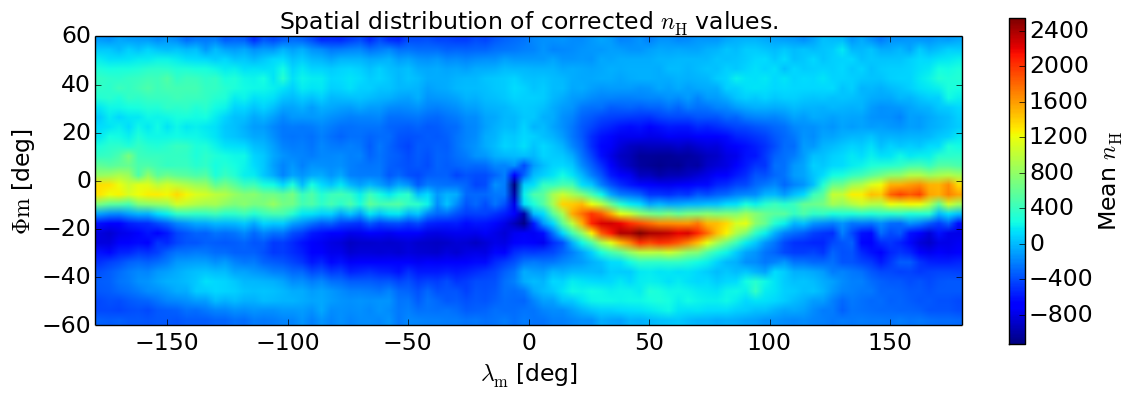

In [51]:
plt.figure(figsize=(12,8), dpi=100)
plt.title(r'Spatial distribution of corrected $n_{\mathrm{H}}$ values.', size=17)

plt.xlabel(r'$\lambda_{\mathrm{m}}$ [deg]', size=17)
plt.ylabel(r'$\Phi{\mathrm{m}}$ [deg]', size=17)
plt.tick_params(labelsize=17)

im = plt.imshow(h_mean_corr.T, interpolation=None,
           extent=[mlon_edges[0], mlon_edges[-1], mlat_edges[0], mlat_edges[-1]]);

cbar = plt.colorbar(fraction=0.0175)
cbar.set_label('Mean $n_{\mathrm{H}}$', size=17)
cbar.ax.tick_params(labelsize=17)

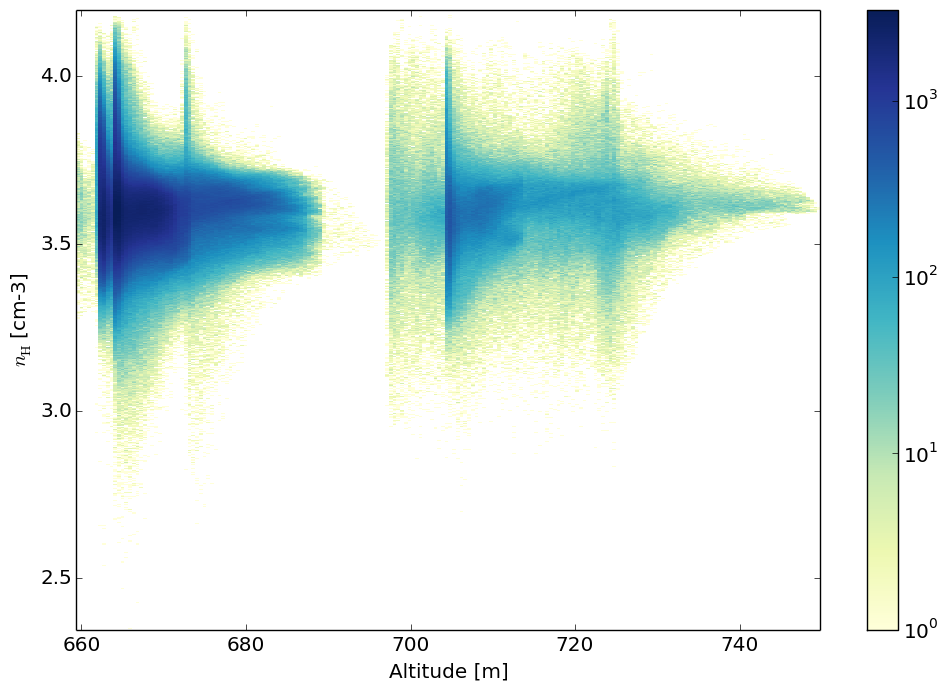

In [62]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

pr.hist2(day['alt'], np.log10(day['h'] - h_corr_mlat - h_corr_cnesjd + 4000),
         axis_labels=['Altitude [m]', r'$n_{\mathrm{H}}$ [cm-3]'], bins=[200, h_binnum])

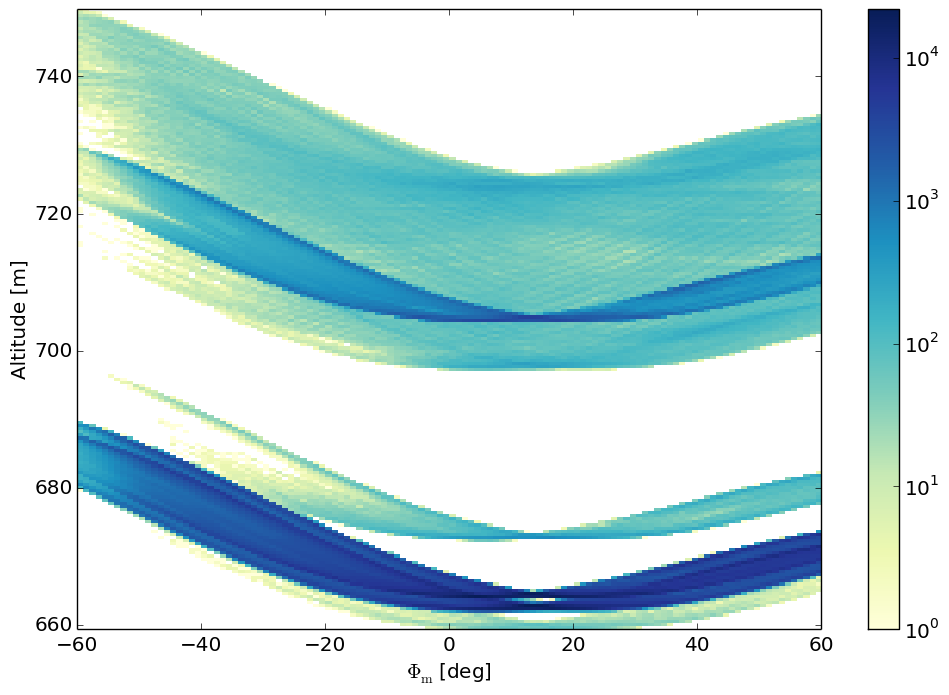

In [64]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

pr.hist2(day['mlat'], day['alt'],
         axis_labels=[r'$\Phi_{\mathrm{m}}$ [deg]', 'Altitude [m]'], bins=[mlat_binnum, 200])

## Auxillary functions

In [ ]:
def calc_dist(x, y, a, b):

    """
    Calculates the distance of points x,y from the line defined by
    the equation: y = ax + b
    """

    from math import sqrt

    return np.abs(a * x - y + b) / sqrt(a * a + 1)